In [ ]:
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Aquisição de dados

In [3]:
# Download dados MT
estado_mt = geobr.read_state(code_state="MT", year=2020, simplified=False)

In [4]:
# Dados de todos os municípios
municipios_mt = geobr.read_municipality(code_muni="MT", year=2020, simplified=False)

In [66]:
# Olhando o CRS (sitema de coordenadas)
print(municipios_mt.crs)

EPSG:4674


In [67]:
# Mudando as coordenadas
crs_projetado = "EPSG:5880"

estado_mt_proj = estado_mt.to_crs(crs_projetado)
municipios_mt_proj = municipios_mt.to_crs(crs_projetado)

In [68]:
print(municipios_mt_proj.crs)

EPSG:5880


# Simulando torres

In [69]:
# Gerando pontos aleatórios dentro da geometria do estado, que seriam as torres

pontos_multipoint = estado_mt_proj.geometry.sample_points(size=50, rng=42)

In [70]:
# Colocando os pontos no gpd
torres_gdf = gpd.GeoDataFrame(geometry=pontos_multipoint, crs=crs_projetado)
torres_gdf["tower_id"] = range(1, len(torres_gdf) + 1)

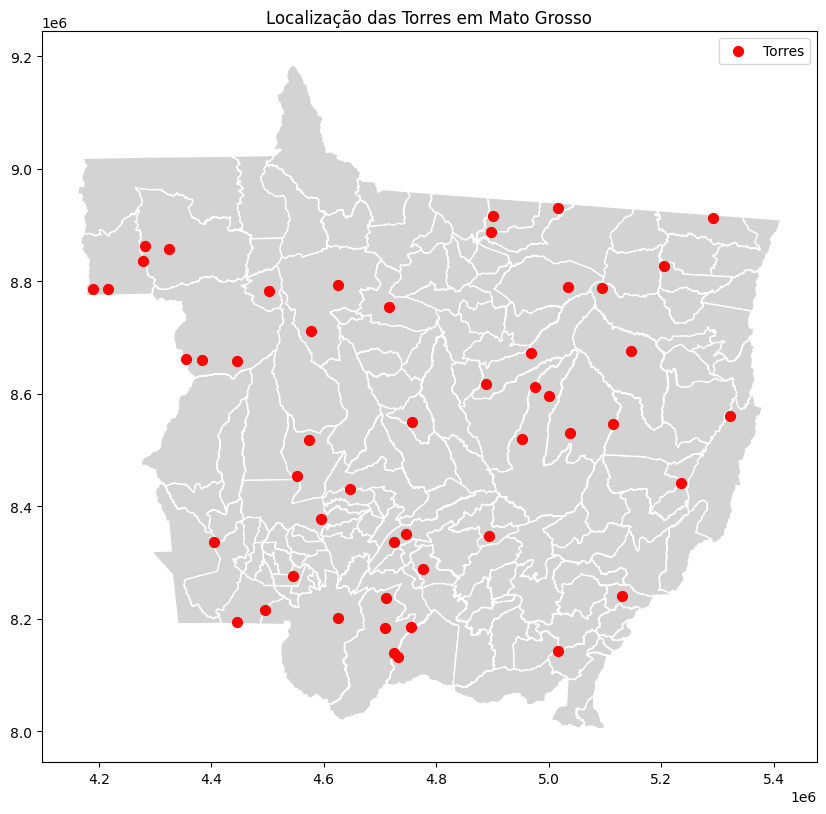

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
municipios_mt_proj.plot(ax=ax, color="lightgray", edgecolor="white")
torres_gdf.plot(ax=ax, color="red", markersize=50, label="Torres")
plt.title("Localização das Torres em Mato Grosso")
plt.legend()
plt.show()

## Colocando um ponto manualmente

In [87]:
# Colocando uma torre na prefeitura de Cuiabá
prefeitura_cuiaba = Point(-56.096133, -15.596521)  # lat, long

In [88]:
torre_prefeitura_cuiaba = gpd.GeoDataFrame(
    {"tower_id": [1]}, geometry=[prefeitura_cuiaba], crs="EPSG:4674"
)

torre_prefeitura_cuiaba_proj = torre_prefeitura_cuiaba.to_crs(crs_projetado)

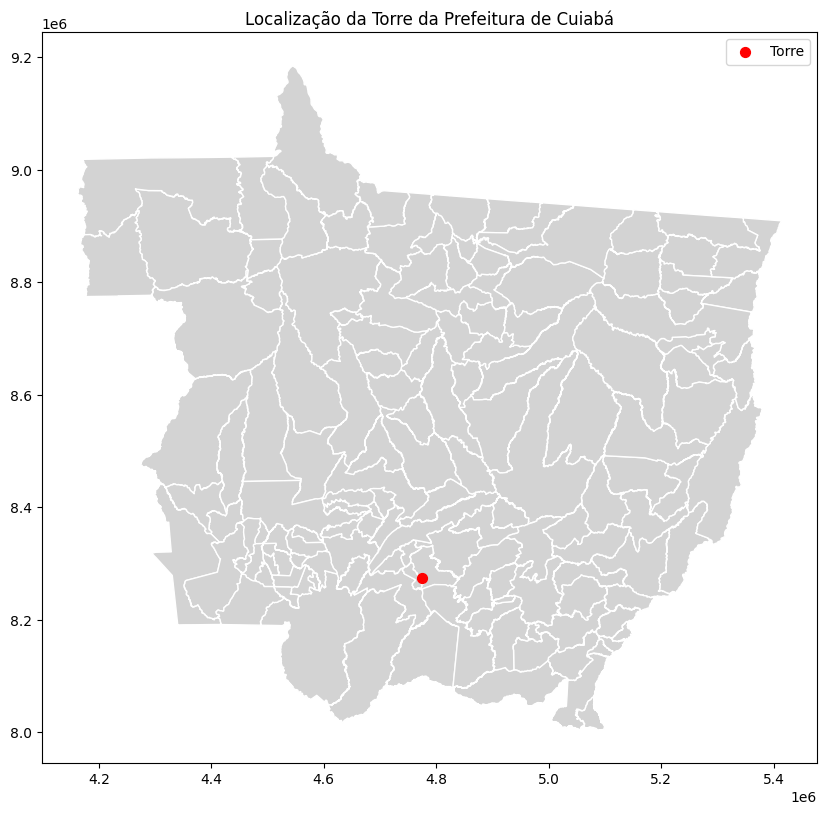

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))
municipios_mt_proj.plot(ax=ax, color="lightgray", edgecolor="white")
torre_prefeitura_cuiaba_proj.plot(ax=ax, color="red", markersize=50, label="Torre")
plt.title("Localização da Torre da Prefeitura de Cuiabá")
plt.legend()
plt.show()

# Modelando cobertura das torres

In [33]:
# Criando um buffer de 50000m (50km) ao redor de cada torre
buffers_geo = torres_gdf.geometry.buffer(50000)

In [ ]:
buffers_gdf = gpd.GeoDataFrame(geometry=buffers_geo, crs=crs_projetado)
buffers_gdf["tower_id"] = torres_gdf["tower_id"]

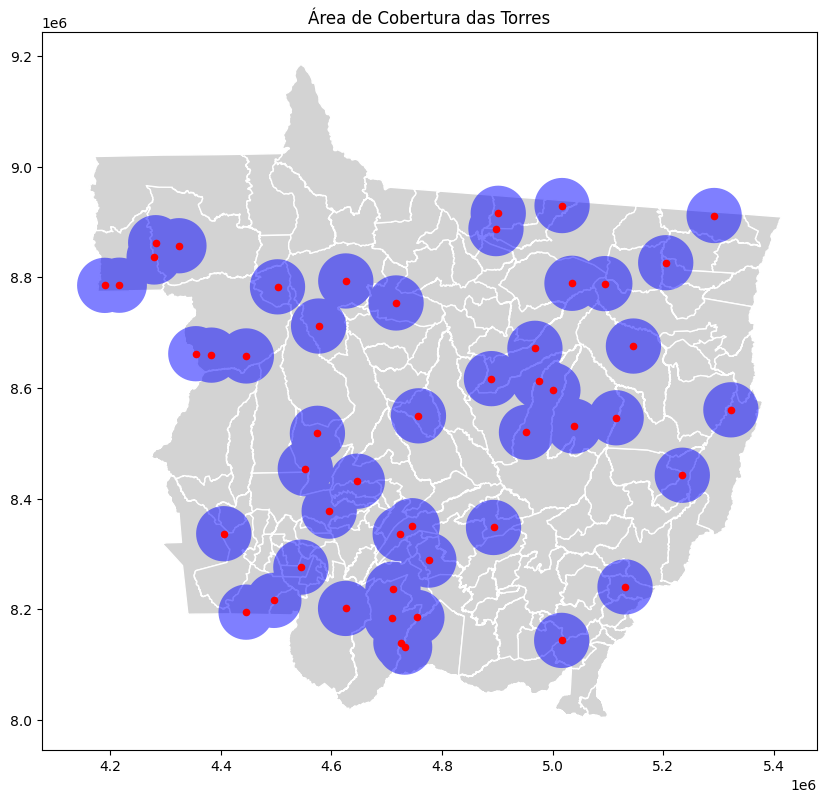

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
municipios_mt_proj.plot(ax=ax, color="lightgray", edgecolor="white")
buffers_gdf.plot(ax=ax, color="blue", alpha=0.5, label="Cobertura (50km)")
torres_gdf.plot(ax=ax, color="red", markersize=20)
plt.title("Área de Cobertura das Torres")
plt.show()

# Quantificando a cobertura das torres por município

In [91]:
# Realizando a interseção espacial
cobertura_municipal = gpd.overlay(buffers_gdf, municipios_mt_proj, how="intersection")

In [ ]:
# Convertendo unidade de medida
cobertura_municipal["coverage_area_sqkm"] = (
    cobertura_municipal.geometry.area / 1000000
).round(2)

municipios_mt_proj["total_area_sqkm"] = (
    municipios_mt_proj.geometry.area / 1000000
).round(2)

In [116]:
cobertura_municipal[["name_muni", "coverage_area_sqkm"]]

,name_muni,coverage_area_sqkm
0,Acorizal,851.42
1,Água Boa,1891.29
2,Alto Boa Vista,29.53
3,Alto Garças,2715.65
4,Alto Paraguai,1769.15
...,...,...
103,Vera,2078.13
104,Vila Rica,4103.36
105,Nova Guarita,402.01
106,Nova Marilândia,1908.67


In [117]:
# Soma as áreas de cobertura por município
cobertura_por_municipio = (
    cobertura_municipal.groupby("name_muni")["coverage_area_sqkm"].sum().reset_index()
)

# Junta com a área total do município
resultado = cobertura_por_municipio.merge(
    municipios_mt_proj[["name_muni", "total_area_sqkm"]], on="name_muni"
)

In [120]:
# Percentual de cobertura
cobertura_municipal["coverage_percent"] = (
    resultado["coverage_area_sqkm"] / resultado["total_area_sqkm"] * 100
).round(2)

In [121]:
cobertura_municipal[["name_muni", "coverage_area_sqkm", "coverage_percent"]]

,name_muni,coverage_area_sqkm,coverage_percent
0,Acorizal,851.42,100.00
1,Água Boa,1891.29,1.31
2,Alto Boa Vista,29.53,70.28
3,Alto Garças,2715.65,95.67
4,Alto Paraguai,1769.15,0.41
...,...,...,...
103,Vera,2078.13,69.13
104,Vila Rica,4103.36,27.96
105,Nova Guarita,402.01,55.12
106,Nova Marilândia,1908.67,100.00


In [ ]:
cobertura_municipal.loc[
    cobertura_municipal["name_muni"] == "Cuiabá",
    ["name_muni", "coverage_area_sqkm", "coverage_percent"],
]


,name_muni,coverage_area_sqkm,coverage_percent
24,Cuiabá,3022.73,40.99


In [124]:
# Agrupando por município e somando as áreas de cobertura
cobertura_por_municipio = (
    cobertura_municipal.groupby("name_muni")["coverage_area_sqkm"].sum().reset_index()
)

In [132]:
area_total_estado = estado_mt_proj.geometry.area.sum() / 1000000

cobertura_total = buffers_gdf.geometry.union_all()

area_total_coberta = cobertura_total.area / 1000000

porcentagem_cobertura_estado = (area_total_coberta / area_total_estado) * 100

print(f"Área total coberta: {area_total_coberta:.2f}km²")
print(f"Porcentagem do estado coberta: {porcentagem_cobertura_estado:.2f}%")

Área total coberta: 318564.09km²
Porcentagem do estado coberta: 35.21%


In [ ]:
# Juntando os dados de cobertura no GeoDataFrame original
municipios_mt_proj = municipios_mt_proj.merge(
    cobertura_por_municipio, on="name_muni", how="left"
).fillna(0)  # Preenchendo municípios sem cobertura com 0


municipios_mt_proj["area_municipio_sqkm"] = municipios_mt_proj.geometry.area / 1000000
municipios_mt_proj["coverage_percent"] = (
    municipios_mt_proj["coverage_area_sqkm"] / municipios_mt_proj["area_municipio_sqkm"]
) * 100

In [137]:
cobertura_municipal[["name_muni", "coverage_area_sqkm", "coverage_percent"]]

,name_muni,coverage_area_sqkm,coverage_percent
0,Acorizal,851.42,100.00
1,Água Boa,1891.29,1.31
2,Alto Boa Vista,29.53,70.28
3,Alto Garças,2715.65,95.67
4,Alto Paraguai,1769.15,0.41
...,...,...,...
103,Vera,2078.13,69.13
104,Vila Rica,4103.36,27.96
105,Nova Guarita,402.01,55.12
106,Nova Marilândia,1908.67,100.00


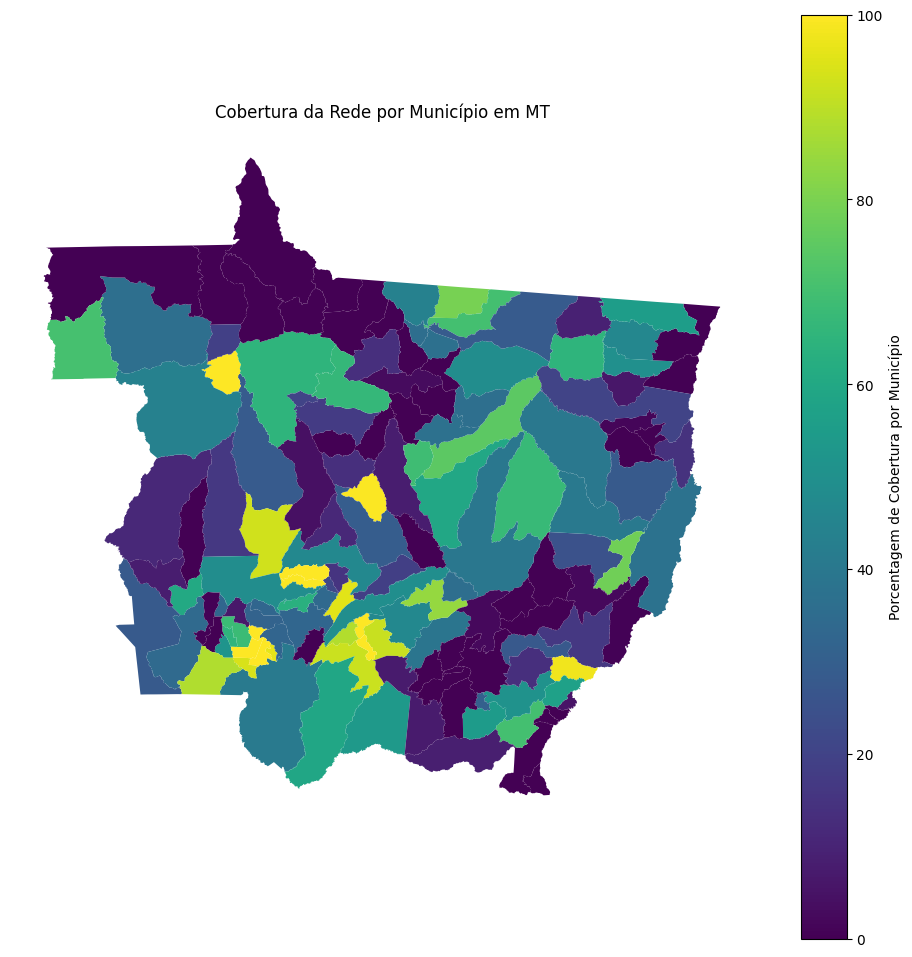

In [ ]:
# Plotando o mapa coroplético
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
municipios_mt_proj.plot(
    column="coverage_percent",
    ax=ax,
    legend=True,
    cmap="viridis",
    legend_kwds={
        "label": "Porcentagem de Cobertura por Município",
        "orientation": "vertical",
    },
)
ax.set_title("Cobertura da Rede por Município em MT")
ax.axis("off")

fig.savefig("../output/mapa_final.png", dpi=300, bbox_inches="tight")

plt.show()